### Step 0: Install and import modules and perform initial setup

In [65]:
!pip install git+https://github.com/earnestt1234/fed3.git -q fed3
!pip install fed3bandit -q fed3bandit
!pip install pingouin -q pingouin

#Importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import datetime
import fed3bandit as f3b
import copy
import math
import os
import tqdm
import fed3
import fed3.plot as fplot
import io
from google.colab import files
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 12, 'figure.autolayout': True})
plt.rcParams['figure.figsize'] = [4, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 16.4 MB/s eta 0:00:00


In [72]:
#plotting function with an unpaired t-test
def bandit_plot(df, variable):
    """Plots a bar and strip plot for a given variable by group with an unpaired t-test."""
    df_filtered = df[df["variable"] == variable]

    # Perform unpaired (independent) t-test
    groups = df_filtered["Group"].unique()
    if len(groups) == 2:  # Ensure we have exactly two groups
        group1 = df_filtered[df_filtered["Group"] == groups[0]]["value"]
        group2 = df_filtered[df_filtered["Group"] == groups[1]]["value"]
        t_test = pg.ttest(group1, group2, paired=False)
        p_value = t_test["p-val"].values[0]
        p_text = f"p = {p_value:.3f}" if p_value >= 0.001 else f"p < 0.001"
    else:
        p_text = "N/A (More than 2 groups)"

    # Plot
    sns.barplot(data=df_filtered, x="Group", y="value", hue="Group", ci=None, alpha=0.8)
    sns.stripplot(data=df_filtered, x="Group", y="value", hue="Group", dodge=False, edgecolor="black", linewidth=1, size=10)

    plt.ylabel(variable)
    plt.xlabel("")
    plt.title(p_text)
    plt.show()

## Step 1: Upload bandit files

Saving FED001_011325_03.CSV to FED001_011325_03 (2).CSV
Saving FED002_011325_00.CSV to FED002_011325_00 (2).CSV
Saving FED003_011325_00.CSV to FED003_011325_00 (2).CSV
Saving FED004_011325_concat.csv to FED004_011325_concat (2).csv
Saving FED005_011325_concat.csv to FED005_011325_concat (2).csv
Saving FED006_011325_03.CSV to FED006_011325_03 (2).CSV
Loaded 6 files: ['FED001_011325_03 (2).CSV', 'FED002_011325_00 (2).CSV', 'FED003_011325_00 (2).CSV', 'FED004_011325_concat (2).csv', 'FED005_011325_concat (2).csv', 'FED006_011325_03 (2).CSV']


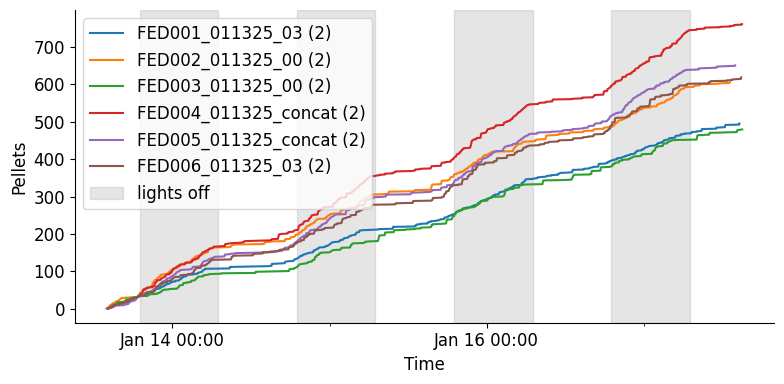

In [83]:
# Upload multiple files
uploaded = files.upload()

# List of loaded FED3 files, only including files > 1KB
feds = [fed3.load(file) for file, data in uploaded.items() if len(data) > 1024]

# Proceed if any files were loaded
if feds:
    fed3.as_aligned(feds, alignment="datetime", inplace=True)

    # Print loaded file names
    loaded_files = [file for file, data in uploaded.items() if len(data) > 1024]
    print(f"Loaded {len(feds)} files: {loaded_files}")

    # Plot raw data
    plt.figure(figsize=(8, 4))
    fplot.line(feds, y='pellets')
    plt.show()
else:
    print("No valid files loaded.")

## Step 2: Pre-Process files

In [73]:
all_files = []
error_list = []
min_row_n = 20

for file in feds:
    c_load_file = file
    c_session_type = c_load_file["Session_Type"]
    #Will return an error if the session type
    if "Bandit" not in c_session_type:
        error_type = "Strange session type"
        error_list.append(error_type)

    #Returns an error if colomun Prob_left is not in the file
    elif "Prob_left" not in c_load_file.columns:
        error_type = "Bandit column not found"
        error_list.append(error_type)

    #Returns an error if there are fewer than min_row_n trials
    elif c_load_file.shape[0] < min_row_n:
        error_type = "Very few trials"
        error_list.append(error_type)

    else:
        #Tries to convert strings to datetimes, returns error if it fails
        try:
            c_load_file[c_load_file.index] = pd.to_datetime(c_load_file.index)

        except:
            error_type = "Failed to convert datetime"

    all_files.append(c_load_file)
print ("Processed files")

Processed files


## Step 3: Calculate bandit metrics

In [74]:
#Analyzing daily metrics
metrics = []
error_mouse = []
for c_df in tqdm.tqdm(all_files):
    mouse_metrics = []
    c_accuracy = f3b.accuracy(c_df)
    c_ws = f3b.win_stay(c_df)
    c_ls = f3b.lose_shift(c_df)
    c_pellets = f3b.count_pellets(c_df)
    c_pokes = f3b.count_pokes(c_df)
    c_pokesperpellet = f3b.pokes_per_pellet(c_df)
    c_rt = c_df["Retrieval_Time"].mean()

    try:
        c_rev_avg = f3b.reversal_peh(c_df, (-10,10), True)
        c_pre_acc = np.mean(c_rev_avg[:10])
        c_post_acc = np.mean(c_rev_avg[11:])

        mouse_metrics.append([c_accuracy, c_ws, c_ls, c_pre_acc, c_post_acc, c_pellets, c_pokes, c_pokesperpellet, c_rt])
    except:
        mouse_metrics.append([c_accuracy, c_ws, c_ls, np.nan, np.nan, c_pellets, c_pokes, c_pokesperpellet, c_rt])

    mouse_metrics_df = pd.DataFrame(mouse_metrics, columns = ["Accuracy", "Win-stay", "Lose-shift", "Pre_rev Acc", "Post_rev Acc", "Pellets", "Pokes", "PokesPerPellet", "RetrievalTime"])
    metrics.append(mouse_metrics_df)

all_metrics = pd.concat(metrics)
all_metrics["File"] = [file.name for file in feds]

all_metrics = pd.melt(all_metrics, id_vars = ["File"])

100%|██████████| 6/6 [00:00<00:00,  6.50it/s]


## Step 4: Group data for plotting

In [91]:
# Define a mapping for File categories
file_mapping = {
    "FED001": "Wildtype",
    "FED002": "Transgenic",
    "FED003": "Wildtype",
    "FED004": "Transgenic",
    "FED005": "Transgenic",
    "FED006": "Wildtype"
}

# Extract the file prefix (e.g., FED001, FED002) and map to category
all_metrics["Group"] = all_metrics["File"].str.extract(r"(FED\d{3})")[0].map(file_mapping)

## Step 5: Plot!

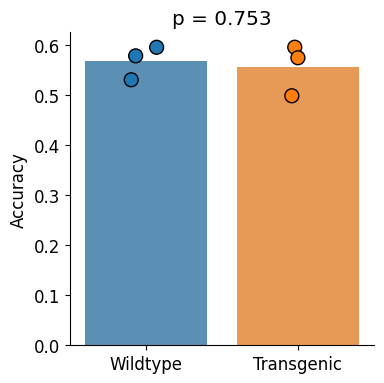

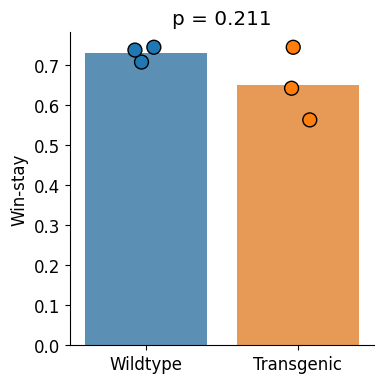

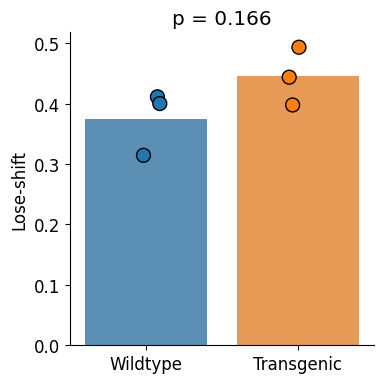

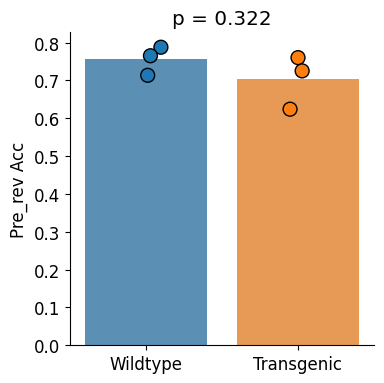

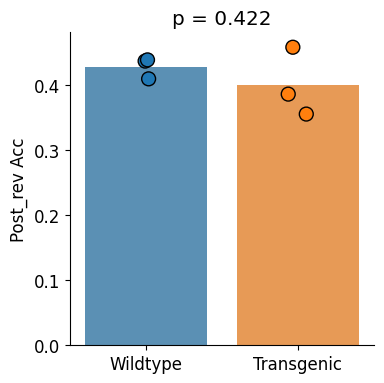

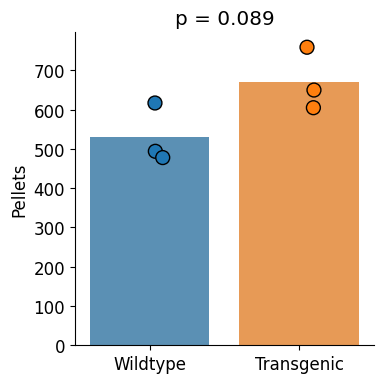

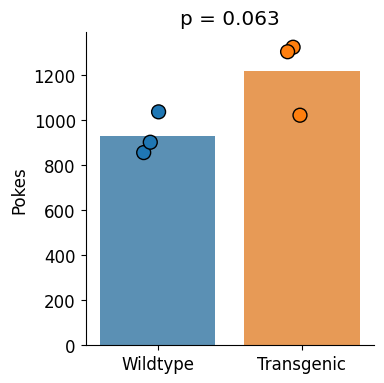

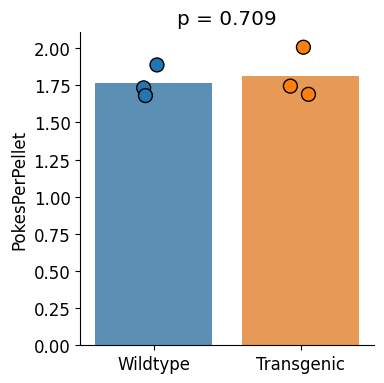

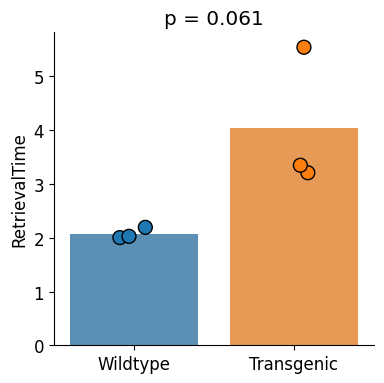

In [82]:
for metric in all_metrics["variable"].unique():
    bandit_plot(all_metrics, metric)

### Visualizing reversal peri-event histogram

6it [00:00, 28.29it/s]


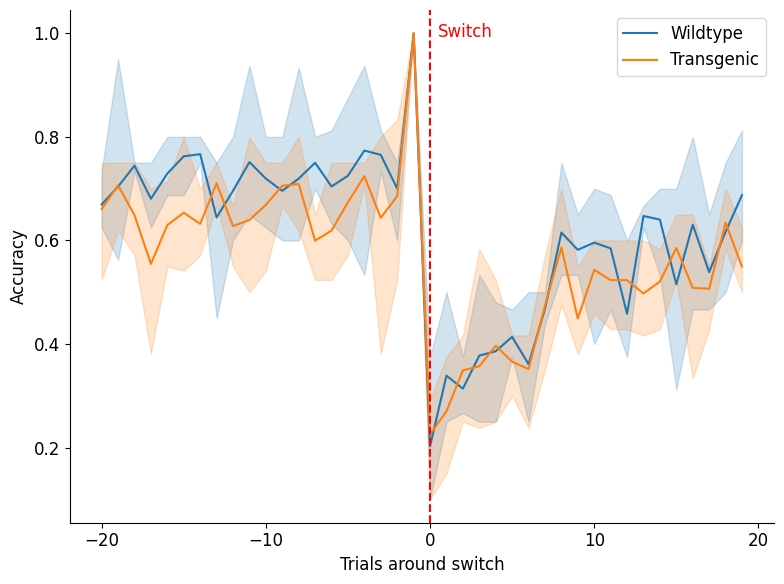

In [167]:
import re
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# set the number of trials to visualize before/after the switch
trials = 20

# Initialize a list to store processed data
data_list = []

# Clean filenames to remove extra characters
clean_filenames = [re.sub(r" \(.*\)", "", fname) for fname in filenames]

# Process each file
for idx, c_df in tqdm.tqdm(enumerate(all_files)):
    filename = clean_filenames[idx]  # Use cleaned filename
    file_id_match = re.search(r"(FED\d{3})", filename)  # Extract "FEDxxx"
    file_id = file_id_match.group() if file_id_match else None

    # Assign genotype based on file_id
    genotype = file_mapping.get(file_id, "Unknown")
    c_rev_avg = f3b.reversal_peh(c_df, (-trials, trials), True)

    if len(c_rev_avg) == 0:
        print(f"Warning: No reversal data for {filename}, skipping...")
        continue  # Skip this file if no data

    # Store results with genotype
    for idx, value in enumerate(c_rev_avg):
        data_list.append({
            "Timepoint": idx - trials,
            "Value": value,
            "Genotype": genotype  # Add genotype to the dataset
        })

# Convert collected data into a DataFrame
rev_avg_df = pd.DataFrame(data_list)

# Plot using seaborn
plt.figure(figsize=(8, 6))
sns.lineplot(data=rev_avg_df, x="Timepoint", y="Value", hue="Genotype")

# Customize x-ticks
plt.xticks([-trials, -trials/2, 0, trials/2, trials])

# Add vertical dashed line at x=0 with label "Switch"
plt.axvline(x=0, color="red", linestyle="dashed", linewidth=1.5)
plt.text(0.5, plt.ylim()[1] * 0.95, "Switch", color="red", fontsize=12, ha="left")

# Add labels
plt.xlabel("Trials around switch")
plt.ylabel("Accuracy")
plt.legend(title="")

# Show plot
plt.show()
